In [2]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_triband_filter_design, make_reflection_design, get_minus_filter_spec

from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle
from designer.script.tmm.get_jacobi_adjoint import get_jacobi_simple as get_jacobi_simple_adjoint
from designer.script.tmm.get_jacobi import get_jacobi_simple


Text(0.5, 0, 'Index of wavelength')

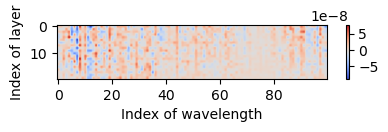

In [ ]:

wls = np.linspace(500, 1000, 100)
d_init = np.random.rand(20) * 100
film = TwoMaterialFilm(1.5, 2.5, 2, d_init)

# ours - jacobi
jacobi = np.zeros((wls.shape[0] * 2, d_init.shape[0]))
get_jacobi_simple_adjoint(
    jacobi, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    0., 
)
jacobi[:wls.shape[0], :] = jacobi[:wls.shape[0], :] * 2

# brute force - jacobi
jacobi_bf = np.zeros((wls.shape[0], d_init.shape[0]))
spec = film.get_spec(0., wls).get_R().copy()
h = 1e-8
for i in range(film.get_d().shape[0]):
    d_old = film.get_d().copy()
    d = d_old.copy()
    d[i] += h
    film.update_d(d)
    spec_new = film.get_spec(0., wls).get_R()
    film.update_d(d_old)
    jacobi_bf[:, i] = (spec_new - spec) / h

fig, ax = plt.subplots(1, 1)
s = ax.imshow((jacobi[:wls.shape[0], :] - jacobi_bf).T, cmap='coolwarm', )
cbar = fig.colorbar(s)
fig.set_size_inches(5, 0.7)

ax.set_ylabel('Index of layer')
ax.set_xlabel('Index of wavelength')

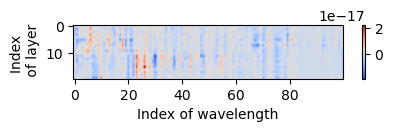

In [8]:

wls = np.linspace(500, 1000, 100)
d_init = np.random.rand(20) * 100
film = TwoMaterialFilm(1.5, 2.5, 2, d_init)

# ours - jacobi
jacobi = np.zeros((wls.shape[0] * 2, d_init.shape[0]))
get_jacobi_simple_adjoint(
    jacobi, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    0., 
)


# brute force - jacobi
jacobi_tfnn = np.zeros((wls.shape[0] * 2, d_init.shape[0]))
get_jacobi_simple(
    jacobi_tfnn,
    wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    0., 
)

fig, ax = plt.subplots(1, 1)
s = ax.imshow((jacobi[:wls.shape[0], :] - jacobi_tfnn[:wls.shape[0], :]).T, cmap='coolwarm', )
cbar = fig.colorbar(s)
fig.set_size_inches(5, 0.7)

ax.set_ylabel('Index \n of layer')
ax.set_xlabel('Index of wavelength')

fig.savefig('./compare_precision_adjoint_tfnn.png', dpi=300, bbox_inches='tight')